# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [1]:
import os
import yaml
import xarray as xr
import rioxarray as rio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import mode
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

import warnings

# Filter RuntimeWarning with the specific message
warnings.filterwarnings(
    "ignore",  # Action: ignore the warning
    category=RuntimeWarning,  # Type of warning
    message="invalid value encountered in cast"  # Specific message to match
    )

# filter warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="angle from rectified to skew grid parameter lost in conversion to CF"
    )

In [2]:
plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

In [21]:
def create_run_path_dict(run_path: str, only_completly_traind: bool=True) -> dict:
    """
    creating dictionary with paths to data for a specific run

    Parameters:
        run_path (str): Path to folder containing the output folders for a series of models.
        data_type (str): Data type ('predictions', 'metrics', 'config').

    Returns:
        a dictionay with the models as keys containing a dictionary with the data types as keys and the paths as values.

        {"model1": {"predictions": path, "metrics": path, "config": path},
    """
    run_path = Path(run_path)

    # get all models
    models = {}
    for subfolder in run_path.iterdir():
        include = False
        if (subfolder / 'config.yaml').exists():
            include = True
            if only_completly_traind:
                #check if "preds.zarr" exists
                if not (subfolder / 'preds.zarr').exists():
                    include = False
        
        if include:
            models[subfolder.name] = {
                'predictions': subfolder / 'preds.zarr',
                'metrics': subfolder / 'metrics.csv',
                'config': subfolder / 'config.yaml'
            }

    return models

# function to load data path from run
def run_data_path(run: str, data_type: str) -> Path:
    """
    getting run data path

    Parameters:
        run (str): Run name.
        data_type (str): Data type ('predictions', 'metrics', 'config').

    Returns:
        path (Path): Path to the run data.
    """

    if data_type == 'predictions':
        target = 'preds.zarr'
    elif data_type == 'metrics':
        target = 'metrics.csv'
    elif data_type == 'config':
        target = 'config.yaml'
    else:
        raise ValueError('Invalid data type. Choose from: "predictions", "metrics", "config".')

    return paths['output_path'] / run / target
    
# function to reduce plotting resolution
def mode_reduction(block, axis):
        # Flatten the block and calculate the mode
        dim0, dim1, dim2, dim3 = block.shape
        flattened = block.transpose((0, 2, 1, 3)).reshape(dim0, dim2, -1)
        result = mode(flattened, axis=-1, nan_policy='omit').mode
        return result

def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    if reduction == 'mode':
        return da.coarsen(x=factor, y=factor, boundary="trim").reduce(mode_reduction).compute()
    else:
        return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def get_mask_ids_dict(area_id_dict: dict) -> dict:

    mask_ids_dict = {}

    for key, value in area_id_dict.items():
        
        mode = key.split('_')[0]
        new_key = f'{mode}_mask_ids'

        value_list = np.array([value] if isinstance(value, int) else value)

        if any(value_list < 0) or any(value_list > 4):
            raise ValueError('`mask_values` must be in range [0, ..., 4]')

        
        mask_values = np.argwhere(np.isin((np.arange(1, 13) - 1) % 4, value_list - 1)).flatten() + 1

        if any(mask_values == 0):
            mask_values = np.concatenate((mask_values, np.zeros(1, dtype=int)))

        mask_ids_dict[new_key] = mask_values

    return mask_ids_dict

def calculate_normalized_rgb(
    rs: xr.Dataset, 
    gamma: float = 1.0, 
    clip_min: float = 0.0, 
    clip_max: float = 1.0
) -> np.ndarray:
    """
    Calculate normalized RGB from an xarray Dataset with optional scaling, gamma correction, and clipping.

    Parameters:
        ds (xr.Dataset): Input dataset containing the bands with dimensions [4, 'x', 'y'].
        gamma (float): Gamma correction factor. Default is 1.0 (no gamma correction).
        clip_min (float): Minimum value for clipping. Default is 0.0.
        clip_max (float): Maximum value for clipping. Default is 1.0.

    Returns:
        np.ndarray: Normalized RGB image as a NumPy array with shape (H, W, 3) and values in [0, 1].
    """
    # Mask zero values with NaN to avoid skewing normalization
    ds = rs.where(rs > 0)

    # Select the respective bands
    red_band = ds.sel(band=2)
    green_band = ds.sel(band=3)
    blue_band = ds.sel(band=4)

    # Scale values to [0, 1] range before any processing
    def scale_to_unit(array):
        return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

    red_scaled = scale_to_unit(red_band)
    green_scaled = scale_to_unit(green_band)
    blue_scaled = scale_to_unit(blue_band)

    # Function to normalize an array with clipping
    def normalize(array):
        # Clip values to specified range
        clipped = np.clip(array, clip_min, clip_max)
        # Normalize to [0, 1]
        return (clipped - np.nanmin(clipped)) / (np.nanmax(clipped) - np.nanmin(clipped))

    # Normalize each band with scaling, clipping, and gamma correction
    red_normalized = normalize(np.power(red_scaled, gamma))
    green_normalized = normalize(np.power(green_scaled, gamma))
    blue_normalized = normalize(np.power(blue_scaled, gamma))

    # Stack bands into an RGB array
    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

    return rgb

def plot_settings(label_type: str, exclude_correct_incorrect: bool=False):
    """
    Get plot settings for the specified label type.

    Parameters:
        label_type (str): Label type ('category', 'sealed', 'sealed_simple').

    Returns:
        legend_elements (list): List of legend elements.
        class_cmap (ListedColormap): Colormap for the classes.
        class_norm (BoundaryNorm): Boundary norm for the classes.

    """

    if label_type == 'category':
        class_info = plot_config['class_info_category']
    
    elif label_type == 'sealed':
        class_info = plot_config['class_info_sealed']

    elif label_type == 'sealed_simple':
        class_info = plot_config['class_info_sealed']
        class_info = {key: value for key, value in class_info.items() if key != 2}

    else:
        raise ValueError('Invalid label type. Choose from: "category", "sealed", "sealed_simple".')

    sorted_classes = sorted(class_info.keys())
    colors = [class_info[key][1] for key in sorted_classes]

    class_cmap = ListedColormap(colors)
    bounds = list(sorted_classes) + [sorted_classes[-1] + 1]
    class_norm = BoundaryNorm(bounds, class_cmap.N)

    diff_info = plot_config['diff_info']

    sorted_classes_diff = sorted(diff_info.keys())
    colors_diff = [diff_info[key][1] for key in sorted_classes_diff]
    diff_cmap = ListedColormap(colors_diff)

    if exclude_correct_incorrect:
        legend_info = {**class_info}
    else:
        legend_info = {**class_info, **diff_info}

    legend_elements = [Patch(facecolor=legend_info[key][1], label=legend_info[key][0]) for key in sorted(legend_info.keys())]

    return legend_elements, class_cmap, class_norm, diff_cmap

In [4]:
# paths
with open('../path_config.yaml', 'r') as file:
    paths = yaml.safe_load(file)
paths = {key: Path(value) for key, value in paths.items()}

with open(paths['plot_config_path'], 'r') as file:
    plot_config = yaml.safe_load(file)

# coordinates
csr = 'EPSG:2056'

area_id_dict = {
    'train_area_ids': [1, 2],
    'valid_area_ids': [3],
    'test_area_ids': [4]
}

mask_ids_dict = get_mask_ids_dict(area_id_dict)

## Visualizations of the available Data

### Size of the 3 areas

In [5]:
# import .shp file
gdf = gpd.read_file(paths['shp_labels'])

mapping_dict = {key: value[0] for key, value in plot_config['class_info_sealed'].items()}
gdf['sealed_label'] = gdf['sealed'].astype(int).replace(mapping_dict)

# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

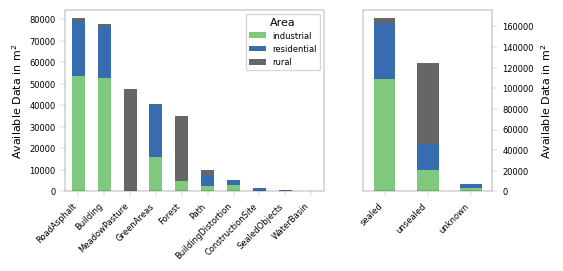

In [6]:
fig_filename = 'area_by_category_and_seal.pdf'
# fig_filename = None

image_size_cm = [14, 6]

# Create GridSpec layout with 5 rows and 4 columns
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(1, 2, width_ratios=[2, 1], height_ratios=[1], figure=fig)

for i, col_name in enumerate(['QA_categor', 'sealed_label']):
# Aggregate the grouped data
    data = gdf.groupby([col_name, 'area'])['Shape_Area'].sum().unstack().fillna(0)

    # Sort the data by the total size of each QA_categor
    data['Total'] = data.sum(axis=1)
    data = data.sort_values('Total', ascending=False).drop(columns='Total')

    # Plot stacked bar chart

    ax = fig.add_subplot(gs[i])
    data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

    ax.set_xlabel(None)
    ax.set_ylabel('Available Data in m$^2$')

    # Rotate x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    if i == 0:
        ax.legend(title='Area')

    else:
        ax.get_legend().remove()
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

if fig_filename is not None:
    plt.savefig(paths["figure_output_path"] / fig_filename, bbox_inches='tight')

plt.show()


## Visualizations of the Results

### Loss and accuracy

In [7]:
def plot_model_metrics(
        model_dict: dict,
        title: str=None,
        type: str='valid', 
        step: bool=False, 
        image_size_cm: list[int,int]=[14,7], 
        window_size: int=5
        ):

    """
    Plot the training and validation metrics of a run.

    Parameters:

        run (str): Run name.
        type (str): Type of metrics ('train', 'valid'). Default is 'valid'.
        step (bool): for type 'train', plot step instead of epoch. Default is False.
        image_size_cm (list): Size of the output image in cm.
        window_size (int): Size of the smoothing window. Default is 5.

    """
    metrics = pd.read_csv(model_dict['metrics'])

    if type == 'valid':
        loss = 'valid_loss'
        acc = 'valid_acc'
        label = ['Validation Loss', 'Validation Accuracy']
    elif type == 'train':
        label = ['Training Loss', 'Training Accuracy']
        if step:
            loss = 'train_loss_step'
            acc = 'train_acc_step'
        else:
            loss = 'train_loss_epoch'
            acc = 'train_acc_epoch'

    validation_data = metrics[~metrics[loss].isnull()]

    # Smooth the data
    smoothed_val_loss = smooth_data(validation_data[loss], window_size=window_size)
    smoothed_val_acc = smooth_data(validation_data[acc], window_size=window_size)

    # Adjust the epoch range to match the length of the smoothed data
    epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

    fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

    plt.title(title)

    # Plot unsmoothed valid_loss on the primary y-axis
    ax1.plot(validation_data['epoch'], validation_data[loss], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_loss on the primary y-axis
    ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label=label[0], linewidth=0.5)


    # Adjust y-axis limits for loss
    loss_min = validation_data[loss].min()
    loss_max = validation_data[loss].max()
    ax1.set_ylim([loss_min * 0.87, loss_max * 1])

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(label[0])
    ax1.tick_params(axis='y')

    # Create a secondary y-axis to plot valid_acc
    ax2 = ax1.twinx()
    # Plot unsmoothed valid_acc on the secondary y-axis
    ax2.plot(validation_data['epoch'], validation_data[acc], color='#FB9A99', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_acc on the secondary y-axis
    ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label=label[0], linewidth=0.5)
    ax2.set_ylabel(label[1])
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2)

    fig.tight_layout()
    
    return fig


### Visualizations of the Predictions

In [8]:
def plot_model_visual(model_dict: dict, title: str=None, image_size_cm: list[int,int]=[16, 22]):
    """
    Plot the visual predictions for a given run.

    Parameters:
        run (str): path relative to run folder.
        image_size_cm (list): Image size in cm default is [16, 22].

    """
    config_path = model_dict['config']
    prediction_path = model_dict['predictions']
    dataset_path = paths['data_path']
    shp_aoi_path = paths['shp_aoi']


    plot_suptitle = title # if None, no suptitle is added

    titles_views = ["RGB", "Labels", "Predictions", "Difference"]

    area_labels = mask_ids_dict['test_mask_ids']


    # loading run config
    with open(config_path, 'r') as file:
        model_config = yaml.safe_load(file)

    label_type = model_config['label_type']

    # load areas
    areas = gpd.read_file(shp_aoi_path)

    # load training data
    ds_data_raw = xr.open_zarr(dataset_path).rio.write_crs(csr)

    rs = ds_data_raw['rs']

    label = ds_data_raw[label_type]
    label = label.where(label != 255, np.nan)

    # load predictions
    predictions = xr.open_zarr(prediction_path).rio.write_crs(csr)['label_pred']

    rgb_list = []
    label_list = []
    pred_list = []
    diff_list = []

    for area_label in area_labels:

        clip_feature = areas[areas['DataLabel'] == area_label]

        rs_clipped = rs.rio.clip(clip_feature.geometry, clip_feature.crs)
        label_clipped = label.rio.clip(clip_feature.geometry, clip_feature.crs)
        pred_clipped = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

        rgb_norm_settings = plot_config['rgb_norm_settings'][f'{area_label}']
        rgb = calculate_normalized_rgb(rs = rs_clipped, **rgb_norm_settings)

        rgb_transposed = rgb.transpose((1, 0, 2))

        label_transposed = label_clipped.transpose('y', 'x')
        pred_transposed = pred_clipped.transpose('y', 'x')

        difference = label_transposed - pred_transposed
        difference_std = xr.where(np.isnan(difference), np.nan, xr.where(difference == 0, 0, 1))

        rgb_list.append(rgb_transposed)
        label_list.append(label_transposed)
        pred_list.append(pred_transposed)
        diff_list.append(difference_std)

    # loading plot settings
    legend_elements, class_cmap, class_norm, diff_cmap = plot_settings(label_type)

    # Create GridSpec layout with 5 rows and 4 columns
    fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
    gs = GridSpec(6, 4, width_ratios=[0.05, 1, 1, 1], height_ratios=[0.05, 1, 1, 1, 1, 0.5], figure=fig)

    if plot_suptitle is not None:
        fig.suptitle(plot_suptitle, fontsize=12)

    # Add rotated titles to the first column (col 0)
    for i, title in enumerate(titles_views):
        ax_title = fig.add_subplot(gs[i+1, 0])  # Create an axis in the (i, 0) position
        ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
        ax_title.axis('off')  # Turn off the axis

    # # Add colorbar axis
    if label_type == 'sealed_simple':
        legend_cols = 2
    else:
        legend_cols = 3

    legend_ax = fig.add_subplot(gs[5, 0:5])
    legend_ax.axis('off')
    legend_ax.legend(
        handles=legend_elements,
        loc='center',
        frameon=False,
        ncol=legend_cols,  # Number of columns for the legend items
        bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
        fontsize=8,  # Smaller font size
        columnspacing=0.5,  # Reduce space between columns
        handletextpad=0.3,  # Reduce space between handles and labels
        borderpad=0.2,  # Reduce padding inside the legend box
        labelspacing=0.2  # Reduce vertical space between labels
    )

    for i, area_label in enumerate(area_labels):

        # add a title for the row
        ax_title = fig.add_subplot(gs[0, i+1])
        ax_title.text(0.5, 0.5, f'Area {area_label}', fontsize=10, va='center', ha='center')
        ax_title.axis('off')

        # plottin RGB
        
        ax_rgb = fig.add_subplot(gs[1, i+1])
        ax_rgb.imshow(rgb_list[i])
        ax_rgb.axis('off')

        # Plotting labels
        
        ax_labels = fig.add_subplot(gs[2, i+1])
        ax_labels.imshow(label_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
        ax_labels.axis('off')

        # Plotting predictions
        
        ax_predictions = fig.add_subplot(gs[3, i+1])
        ax_predictions.imshow(pred_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
        ax_predictions.axis('off')

        # Plotting difference
        
        ax_difference = fig.add_subplot(gs[4, i+1])
        ax_difference.imshow(diff_list[i], cmap=diff_cmap, interpolation="nearest")
        ax_difference.axis('off')


    plt.subplots_adjust(
        hspace=0.1,  # Adjust vertical spacing
        wspace=0.1   # Adjust horizontal spacing
    )

    fig.tight_layout()

    return fig
    

In [9]:
def calculate_prediction_qualiyty(model_dict: dict):

    config_path = model_dict['config']
    prediction_path = model_dict['predictions']
    dataset_path = paths['data_path']
    shp_aoi_path = paths['shp_aoi']

    mask_areas = mask_ids_dict['test_mask_ids']

    # loading run config
    with open(config_path, 'r') as file:
        model_config = yaml.safe_load(file)

    label_type = model_config['label_type']

    # load areas
    areas = gpd.read_file(shp_aoi_path)

    # load training data
    ds_data_raw = xr.open_zarr(dataset_path)

    mask = ds_data_raw['mask']
    label_all = ds_data_raw[label_type]
    label_all = label_all.where(label_all != 255, np.nan)

    # load predictions
    pred_all = xr.open_zarr(prediction_path)['label_pred']

    filtered_mask = mask.where(mask.isin(mask_areas))
    label_clipped = label_all.where(filtered_mask.notnull())
    pred_clipped = pred_all.where(filtered_mask.notnull())

    label_flat = label_clipped.values.flatten()
    pred_flat = pred_clipped.values.flatten()

    nan_mask = np.isnan(label_flat) | np.isnan(pred_flat)

    label_nonan = label_flat[~nan_mask]
    pred_nonan = pred_flat[~nan_mask]

    f1_weighted = f1_score(label_nonan, pred_nonan, average='weighted')
    f1_per_class = f1_score(label_nonan, pred_nonan, average=None)
    acc = accuracy_score(label_nonan, pred_nonan)

    list_to_exclude = ['dev_run', 'device', 'disable_progress_bar', 'output_path', 'overwrite']
    filtered_model_config = {key: value for key, value in model_config.items() if key not in list_to_exclude}

    all_metrics = {
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'accuracy': acc,
        **model_config
    }

    return all_metrics


In [10]:
def evaluate_all_models(run_path: str, save_path: str=None, show_plots: bool=False, add_plot_titles: bool=False, do_plots: bool=False):

    models = create_run_path_dict(run_path, only_completly_traind=True)

    if save_path is not None:

        save_path = Path(save_path)
        save_plot_path = save_path / 'plots'

        if not save_path.exists():
            save_plot_path.mkdir(parents=True)
        else:
            if do_plots:
                raise ValueError(f"Path {save_path} already exists.")
            else:
                file_path = save_path / 'quality_eval.csv'
                if file_path.exists():
                    file_path.unlink()

    num_models = len(models)
    counter = 1

    quality_eval_list = []

    for key, value in models.items():
        print(f"Calculating model {counter} of {num_models}")

        if do_plots:

            if add_plot_titles:
                plot_title = key
            else:
                plot_title = None


            visual = plot_model_visual(model_dict=value, title=plot_title)
            metric = plot_model_metrics(model_dict=value, title=plot_title, type='valid', step=True)

            if save_path is not None:
                visual.savefig(save_plot_path / f'{key}_visual.pdf')
                metric.savefig(save_plot_path / f'{key}_metric.pdf')
            if show_plots:
                plt.show()
            else:
                plt.close(visual)
                plt.close(metric)

        quality_eval = calculate_prediction_qualiyty(model_dict=value)

        quality_eval.update({
            'model_designation': key,
            })

        quality_eval_list.append(quality_eval)

        counter += 1

    quality_eval_df = pd.DataFrame(quality_eval_list)

    if save_path is not None:
        quality_eval_df.to_csv(save_path / 'quality_eval.csv')

    return quality_eval_df


#### Plot for best Model

In [29]:
# Data for incorrect per category
run_path = paths['output_path'] / "final_models"
models = create_run_path_dict(run_path, only_completly_traind=True)
model_dict = models['sealed_simple_augment_lr0.0001_wd0.1']

config_path = model_dict['config']
prediction_path = model_dict['predictions']
dataset_path = paths['data_path']
shp_aoi_path = paths['shp_aoi']

area_labels = [8, 12]

# load areas
areas = gpd.read_file(shp_aoi_path)

# load training data
ds_data_raw = xr.open_zarr(dataset_path).rio.write_crs(csr)

rs = ds_data_raw['rs']

label = ds_data_raw['sealed_simple']
label = label.where(label != 255, np.nan)

category = ds_data_raw['category']
category = category.where(category != 255, np.nan)

# load predictions
predictions = xr.open_zarr(prediction_path).rio.write_crs(csr)['label_pred']

rgb_list = []
category_where_correct_list = []
category_where_incorrect_list = []

for area_label in area_labels:

    clip_feature = areas[areas['DataLabel'] == area_label]

    rs_clipped = rs.rio.clip(clip_feature.geometry, clip_feature.crs)
    label_clipped = label.rio.clip(clip_feature.geometry, clip_feature.crs)
    pred_clipped = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)
    category_clipped = category.rio.clip(clip_feature.geometry, clip_feature.crs)

    rgb_norm_settings = plot_config['rgb_norm_settings'][f'{area_label}']
    rgb = calculate_normalized_rgb(rs = rs_clipped, **rgb_norm_settings)

    rgb_transposed = rgb.transpose((1, 0, 2))

    label_transposed = label_clipped.transpose('y', 'x')
    pred_transposed = pred_clipped.transpose('y', 'x')
    category_transposed = category_clipped.transpose('y', 'x')

    difference = label_transposed - pred_transposed

    correct_mask = xr.where(difference == 0, 1, np.nan)

    non_zero_mask = xr.where(difference != 0, 1, np.nan)
    incorrect_mask = xr.where(difference.isnull(), np.nan, non_zero_mask)

    category_where_correct = category_transposed.where(correct_mask == 1)
    category_where_incorrect = category_transposed.where(incorrect_mask == 1)

    rgb_list.append(rgb_transposed)
    category_where_correct_list.append(category_where_correct)
    category_where_incorrect_list.append(category_where_incorrect)


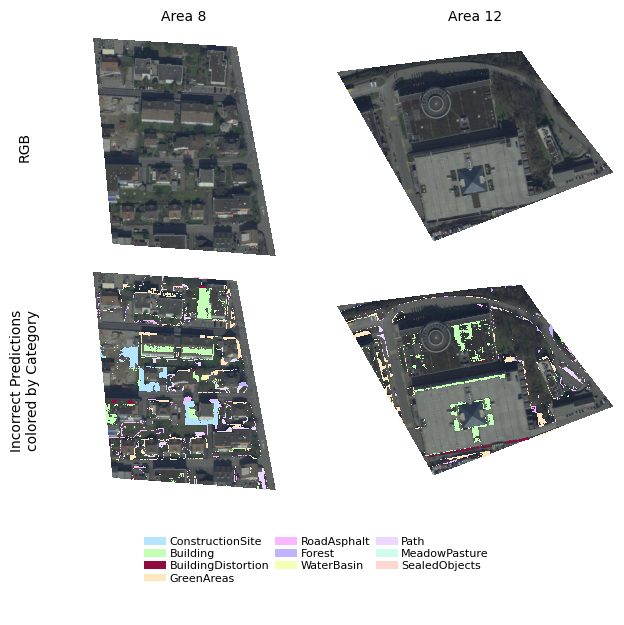

In [49]:
fig_filename = 'incorrect_per_category.pdf'

image_size_cm=[16, 16]
titles_views = ["RGB", "Incorrect Predictions\ncolored by Category"]
plot_suptitle = None

# loading plot settings
legend_elements, class_cmap, class_norm, diff_cmap = plot_settings('category', exclude_correct_incorrect=True)

# Create GridSpec layout with 5 rows and 4 columns
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(4, 3, width_ratios=[0.05, 1, 1], height_ratios=[0.05, 1, 1, 0.5], figure=fig)

if plot_suptitle is not None:
    fig.suptitle(plot_suptitle, fontsize=12)

# Add Titles for cols
for i, title in enumerate(titles_views):
    ax_title = fig.add_subplot(gs[i+1, 0])
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
    ax_title.axis('off')  # Turn off the axis

# # Add Legend
legend_ax = fig.add_subplot(gs[3, 0:4])
legend_ax.axis('off')
legend_ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=False,
    ncol=3,  # Number of columns for the legend items
    bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
    fontsize=8,  # Smaller font size
    columnspacing=0.5,  # Reduce space between columns
    handletextpad=0.3,  # Reduce space between handles and labels
    borderpad=0.2,  # Reduce padding inside the legend box
    labelspacing=0.2  # Reduce vertical space between labels
)

for i, area_label in enumerate(area_labels):

    title = f'Area {area_label}'
    ax_title = fig.add_subplot(gs[0, i+1])  # Create an axis in the (i, 0) position
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center')
    ax_title.axis('off')  # Turn off the axis

    ax_overlay_correct = fig.add_subplot(gs[1, i+1])
    ax_overlay_correct.imshow(rgb_list[i])
    # ax_overlay_correct.imshow(category_where_correct_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest", alpha=0.0)
    ax_overlay_correct.axis('off')

    ax_overlay_incorrect = fig.add_subplot(gs[2, i+1])
    ax_overlay_incorrect.imshow(rgb_list[i], alpha=1)
    ax_overlay_incorrect.imshow(category_where_incorrect_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest", alpha=1)
    ax_overlay_incorrect.axis('off')

plt.subplots_adjust(
        hspace=0,  # Adjust vertical spacing
        wspace=0   # Adjust horizontal spacing
    )

if fig_filename is not None:
    plt.savefig(paths["figure_output_path"] / fig_filename, bbox_inches='tight')

fig.tight_layout()
plt.show()


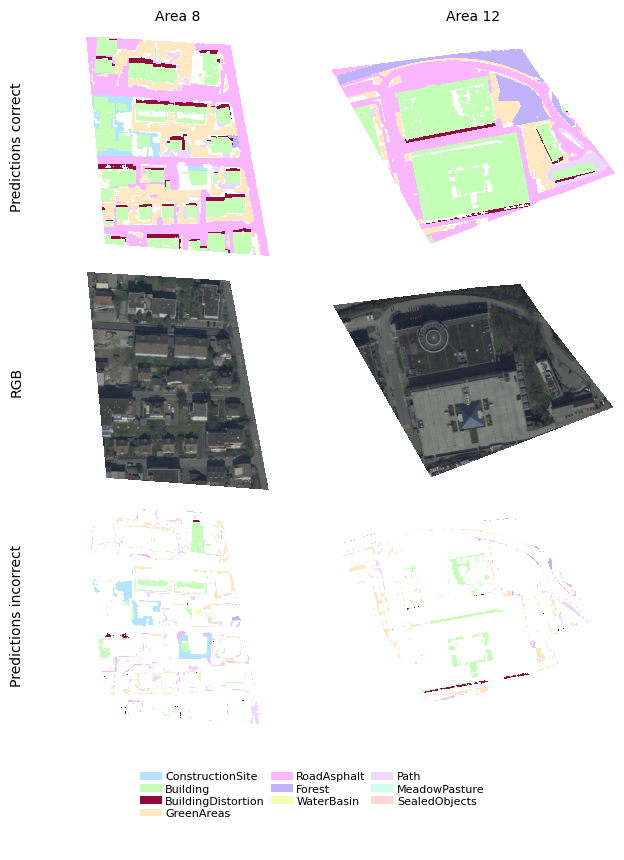

In [31]:
fig_filename = None

image_size_cm=[16, 22]
plot_suptitle = None 
titles_views = ["Predictions correct", "RGB", "Predictions incorrect"]
# loading plot settings
legend_elements, class_cmap, class_norm, diff_cmap = plot_settings('category', exclude_correct_incorrect=True)

# Create GridSpec layout with 5 rows and 4 columns
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(5, 3, width_ratios=[0.05, 1, 1], height_ratios=[0.05, 1, 1, 1, 0.5], figure=fig)

if plot_suptitle is not None:
    fig.suptitle(plot_suptitle, fontsize=12)

# Add Titles for cols
for i, title in enumerate(titles_views):
    ax_title = fig.add_subplot(gs[i+1, 0])
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
    ax_title.axis('off')  # Turn off the axis

# # Add Legend
legend_ax = fig.add_subplot(gs[4, 0:4])
legend_ax.axis('off')
legend_ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=False,
    ncol=3,  # Number of columns for the legend items
    bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
    fontsize=8,  # Smaller font size
    columnspacing=0.5,  # Reduce space between columns
    handletextpad=0.3,  # Reduce space between handles and labels
    borderpad=0.2,  # Reduce padding inside the legend box
    labelspacing=0.2  # Reduce vertical space between labels
)

for i, area_label in enumerate(area_labels):

    title = f'Area {area_label}'
    ax_title = fig.add_subplot(gs[0, i+1])  # Create an axis in the (i, 0) position
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center')
    ax_title.axis('off')  # Turn off the axis

    # plotting correct predictions
    ax_correct = fig.add_subplot(gs[1, i+1])
    ax_correct.imshow(category_where_correct_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax_correct.axis('off')

    # plottin RGB
    ax_rgb = fig.add_subplot(gs[2, i+1])
    ax_rgb.imshow(rgb_list[i])
    ax_rgb.axis('off')


    # plotting incorrect predictions
    ax_incorrect = fig.add_subplot(gs[3, i+1])
    ax_incorrect.imshow(category_where_incorrect_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax_incorrect.axis('off')

if fig_filename is not None:
    plt.savefig(paths["figure_output_path"] / fig_filename, bbox_inches='tight')

fig.tight_layout()
plt.show()


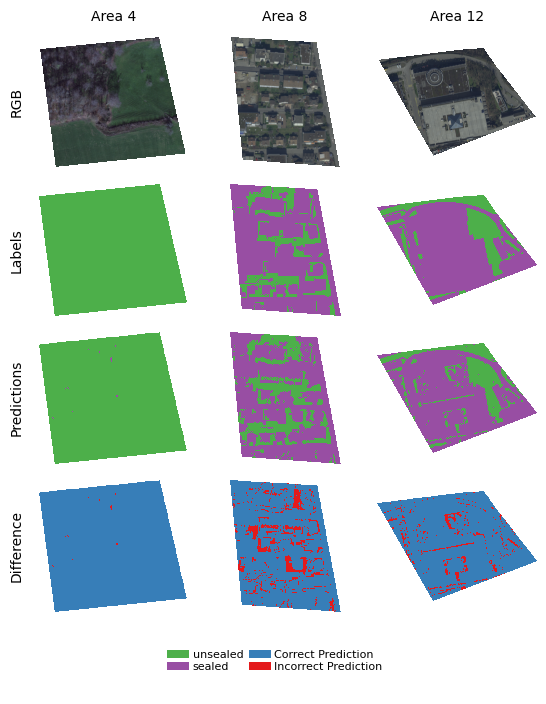

In [26]:
save_path=paths['figure_output_path'] / 'best_model_visual.pdf'

best_model_plot = plot_model_visual(model_dict=best_model, title=None, image_size_cm=[14, 18])

best_model_plot.savefig(save_path, bbox_inches='tight')
plt.show()

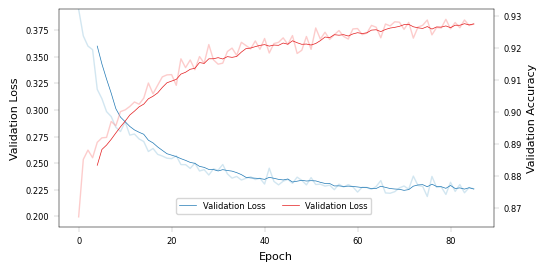

In [13]:
save_path=paths['figure_output_path'] / 'best_model_training_metrics.pdf'

best_model_loss = plot_model_metrics(model_dict=best_model, window_size=5, image_size_cm=[14, 7])

best_model_loss.savefig(save_path, bbox_inches='tight')
plt.show()


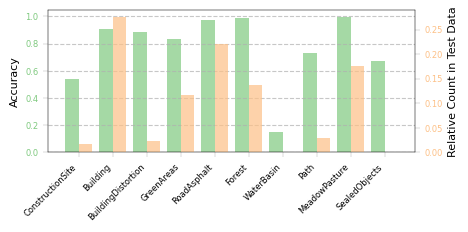

In [14]:
# Evaluate accuracy per category for the best model

save_path=paths['figure_output_path'] / 'best_model_accuracy_per_category.pdf'
image_size_cm = [12, 6]

model = best_model

config_path = model['config']
prediction_path = model['predictions']
dataset_path = paths['data_path']
shp_aoi_path = paths['shp_aoi']

mask_areas = mask_ids_dict['test_mask_ids']

# loading run config
with open(config_path, 'r') as file:
    model_config = yaml.safe_load(file)

# load areas
areas = gpd.read_file(shp_aoi_path)

# load training data
ds_data_raw = xr.open_zarr(dataset_path)

mask = ds_data_raw['mask']
label_all = ds_data_raw['sealed_simple']
label_all = label_all.where(label_all != 255, np.nan)

category_all = ds_data_raw['category']
category_all = category_all.where(category_all != 255, np.nan)

# load predictions
pred_all = xr.open_zarr(prediction_path)['label_pred']

filtered_mask = mask.where(mask.isin(mask_areas))

category_clipped = category_all.where(filtered_mask.notnull())
label_clipped = label_all.where(filtered_mask.notnull())
pred_clipped = pred_all.where(filtered_mask.notnull())

category_flat = category_clipped.values.flatten()
label_flat = label_clipped.values.flatten()
pred_flat = pred_clipped.values.flatten()

nan_mask = np.isnan(label_flat) | np.isnan(pred_flat) | np.isnan(category_flat)

category_nonan = category_flat[~nan_mask]
label_nonan = label_flat[~nan_mask]
pred_nonan = pred_flat[~nan_mask]

category = category_nonan.astype(int)
label = label_nonan.astype(int)
pred = pred_nonan.astype(int)

unique_category = np.unique(category)
total_data = len(category)

eval_per_category_data = []

for element in unique_category:

    category_name = plot_config['class_info_category'][element][0]

    category_filter = category == element

    label_filtered = label[category_filter]
    pred_filtered = pred[category_filter]

    count = len(label_filtered)
    relative_count = count / total_data

    accuracy = accuracy_score(label_filtered, pred_filtered)
    f1_weighted = f1_score(label_filtered, pred_filtered, average='weighted')
    f1_per_class = f1_score(label_filtered, pred_filtered, average=None)

    eval_per_category_data.append({
        'category': element,
        'category_name': category_name,
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'count': count,
        'relative_count': relative_count
        })
    
eval_per_category = pd.DataFrame(eval_per_category_data)

df = eval_per_category

fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

color_accuracy = '#7fc97f'
color_count = '#fdc086'

bar_width = 0.4  # Width of the bars
x = np.arange(len(df['category_name']))  # X positions for categories

# Plot accuracy bars (primary y-axis)
bars1 = ax1.bar(x - bar_width / 2, df['accuracy'], bar_width, color=color_accuracy, alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', labelcolor=color_accuracy)
ax1.set_xticks(x)
ax1.set_xticklabels(df['category_name'], rotation=45, ha='right')

# Create a secondary y-axis for relative_count
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width / 2, df['relative_count'], bar_width, color=color_count, alpha=0.7, label='Relative Count')
ax2.set_ylabel('Relative Count in Test Data')
ax2.tick_params(axis='y', labelcolor=color_count)

# # Add legends
# ax1.legend(bars1, ['Accuracy'], loc='upper left')
# ax2.legend(bars2, ['Relative Count'], loc='upper right')

# Add grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)

if save_path is not None:
    fig.savefig(save_path, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Executing evaluation for all

In [15]:
# out_path = paths['project_path'] / 'evaluation' / 'eval_v2'
# run_path = paths['output_path'] / "final_models"

# quality_eval_df = evaluate_all_models(run_path=run_path, save_path=out_path, show_plots=True, add_plot_titles=False, do_plots=False)

### Comparing Models

In [16]:
# create a latex table

csv_path = paths['project_path'] / 'evaluation' / 'eval_v2' / 'quality_eval.csv'
quality_eval_df = pd.read_csv(csv_path)

# List of original columns
cols = ['label_type', 'use_data_augmentation', 'learning_rate', 'weight_decay', 'accuracy', 'f1_weighted']

# List of new column names for display
display_cols = ['Label Type', 'Data Augmentation', 'Learning Rate', 'Weight Decay', 'Accuracy', 'F1 Score']

# Copy the DataFrame and rename columns
df_display = quality_eval_df[cols].copy()
df_display.columns = display_cols

# Sort values by accuracy and generate LaTeX table
df_display = df_display.sort_values('Accuracy', ascending=False)
latex_table = df_display.to_latex(index=False, float_format="%.4f", column_format="|l|l|r|r|r|r|", 
                                   caption="Accuracy and F1 Score for All Trained Models", 
                                   label="tab:accuracy_f1_table")

# Print the LaTeX table
print(latex_table)

\begin{table}
\caption{Accuracy and F1 Score for All Trained Models}
\label{tab:accuracy_f1_table}
\begin{tabular}{|l|l|r|r|r|r|}
\toprule
Label Type & Data Augmentation & Learning Rate & Weight Decay & Accuracy & F1 Score \\
\midrule
sealed_simple & True & 0.0001 & 0.1000 & 0.9274 & 0.9275 \\
sealed_simple & False & 0.0001 & 0.0100 & 0.9109 & 0.9112 \\
sealed_simple & True & 0.0010 & 0.1000 & 0.9069 & 0.9072 \\
sealed_simple & True & 0.0001 & 0.0100 & 0.9034 & 0.9038 \\
sealed_simple & True & 0.0010 & 0.0000 & 0.9028 & 0.9032 \\
sealed_simple & False & 0.0010 & 0.1000 & 0.9021 & 0.9024 \\
sealed_simple & True & 0.0001 & 0.0000 & 0.9007 & 0.9011 \\
sealed_simple & False & 0.0001 & 0.1000 & 0.9000 & 0.9004 \\
sealed_simple & False & 0.0010 & 0.0100 & 0.8999 & 0.9001 \\
sealed_simple & False & 0.0010 & 0.0000 & 0.8996 & 0.9000 \\
sealed_simple & True & 0.0010 & 0.0100 & 0.8980 & 0.8984 \\
sealed_simple & False & 0.0001 & 0.0000 & 0.8977 & 0.8980 \\
sealed & False & 0.0010 & 0.0100 & 0.88

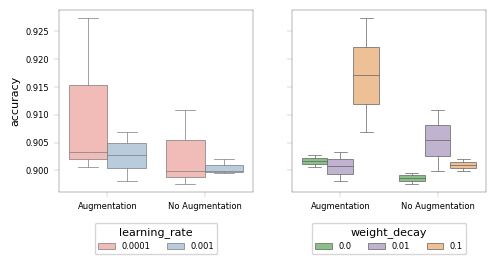

In [18]:
save_path=paths['figure_output_path'] / 'hp_tuning_boxplot.pdf'

image_size_cm = [14, 6]

csv_path = paths['project_path'] / 'evaluation' / 'eval_v2' / 'quality_eval.csv'

quality_eval_df = pd.read_csv(csv_path)

cols = ['model_designation', 'f1_weighted', 'f1_per_class', 'accuracy', 'learning_rate', 'weight_decay', 'label_type', 'use_data_augmentation']
filtered_cols_data = quality_eval_df.sort_values('accuracy', ascending=False)[cols]

data = filtered_cols_data.where(filtered_cols_data['label_type'] == 'sealed_simple').dropna()

data['augmentation'] = data['use_data_augmentation'].replace({True: 'Augmentation', False: 'No Augmentation'})

fig, axes = plt.subplots(1, 2, figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54), sharex=True)

for i, (hp, cmap) in enumerate(zip(
        ['learning_rate', 'weight_decay'],
        ['Pastel1', 'Accent'])):
    ax = axes[i]
    sns.boxplot(
        data=data,
        x='augmentation',
        y='accuracy',
        whis=2,
        linewidth=0.5,
        fliersize=0.5,
        palette=cmap,
        hue=hp,
        ax=ax)
    
    ax.set_xlabel('')
    # sns.move_legend(ax, 'lower left', ncols=3)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title=f'{hp}', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

if save_path is not None:
    fig.savefig(save_path, bbox_inches='tight')
    
plt.show()

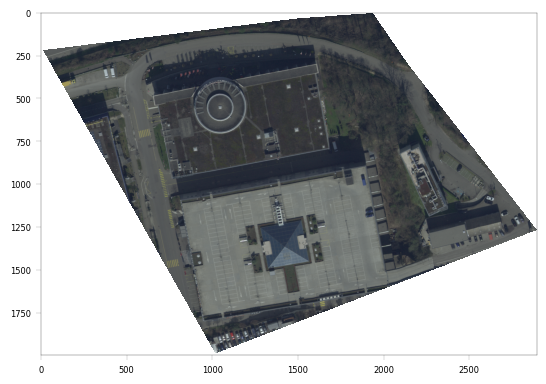

In [19]:
# test rgb norm settings

dataset_path = paths['data_path']
shp_aoi_path = paths['shp_aoi']

area_labels = mask_ids_dict['test_mask_ids']


areas = gpd.read_file(shp_aoi_path)

    # load training data
ds_data_raw = xr.open_zarr(dataset_path).rio.write_crs(csr)

rs = ds_data_raw['rs']


rgb_list = []


# for area_label in area_labels:

clip_feature = areas[areas['DataLabel'] == 12]

rs_clipped = rs.rio.clip(clip_feature.geometry, clip_feature.crs)

rgb_norm_settings = {
    'gamma': 0.25,
    'clip_min': 0.2,
    'clip_max': 0.8
}

rgb = calculate_normalized_rgb(rs = rs_clipped, **rgb_norm_settings)

rgb_transposed = rgb.transpose((1, 0, 2))

plt.imshow(rgb_transposed)
